# Analysis pipeline for Specificity

## Preliminaries

In [1]:
%cd ~/code/textrec/

/Users/kcarnold/code/textrec


In [2]:
%matplotlib inline
import datetime
import json
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import toolz
from IPython.display import Image, HTML

In [3]:
from textrec.paths import paths
from textrec import analysis_util, util, notebook_util, automated_analyses
reload(analysis_util), reload(util), reload(notebook_util), reload(automated_analyses)
from textrec.notebook_util import images, id2img, id2url, show_images

Loading COCO captions
Loading COCO id2url
Done


/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loading ONMT models...
coco_lm_adam_acc_46.00_ppl_16.32_e10_nooptim.pt
Loading model parameters.
coco_cap_adam_acc_48.73_ppl_12.56_e10_nooptim.pt
Loading model parameters.
Ready.
Loading SpaCy...done
Loading COCO captions
Loading COCO id2url
Done
Loading SpaCy...done


In [4]:
# HTML(show_images([images_by_split['val'][0]['cocoid']]))

## Load results of writing experiment

Prerequisites: Run `textrec.logs_to_csv {batch_name}` and `textrec.gruntwork {batch_name}`.

In [5]:
batch = 'spec1'
experiment_level_data = pd.read_csv(paths.analyzed / f'experiment_{batch}.csv')
block_level_data = pd.read_csv(paths.analyzed / f'block_{batch}.csv')
trial_level_data = pd.read_csv(paths.analyzed / f'trial_withmanual_{batch}.csv')
helpful_ranks_by_condition = pd.read_csv(paths.analyzed / f'helpful_ranks_by_condition_{batch}.csv').set_index('index')

In [6]:
def savefig(fn):
    plt.savefig(str(paths.figures / f'{batch}_{fn}.pdf'))

In [7]:
data = dict(
    num_participants=len(set(trial_level_data.participant)),
    non_male=(experiment_level_data.gender == 'Male').sum(),
    num_trials_per=trial_level_data.groupby('participant').size().mean(),
    n_trials=len(trial_level_data))

In [8]:
data['helpful_most_votes'] = helpful_ranks_by_condition.loc[:,[col for col in helpful_ranks_by_condition.columns if 'most' in col]].sum(axis=1).to_dict()
data['helpful_most_votes']

{'general': 15, 'norecs': 6, 'specific': 54}

In [9]:
data['helpful_least_votes'] = helpful_ranks_by_condition.loc[:,[col for col in helpful_ranks_by_condition.columns if 'least' in col]].sum(axis=1).to_dict()

In [10]:
HTML("Each of {num_participants} participants ({non_male} non-male) completed {num_trials_per} trials per experiment, for a total of {n_trials} trials.".format_map(data))

In [11]:
HTML("Participants spent {total_time_mean:.1f} +- {total_time_std:.1f} minutes total.".format(
    total_time_mean=experiment_level_data.total_time.mean(),
    total_time_std=experiment_level_data.total_time.std()))

In [12]:
experiment_level_data.columns

Index(['participant', 'age', 'english_proficiency', 'gender',
       'helpfulRank-accurate-least-condition',
       'helpfulRank-accurate-least-idx', 'helpfulRank-accurate-most-condition',
       'helpfulRank-accurate-most-idx', 'helpfulRank-quick-least-condition',
       'helpfulRank-quick-least-idx', 'helpfulRank-quick-most-condition',
       'helpfulRank-quick-most-idx', 'helpfulRank-specific-least-condition',
       'helpfulRank-specific-least-idx', 'helpfulRank-specific-most-condition',
       'helpfulRank-specific-most-idx', 'other', 'techDiff', 'total_time',
       'use_predictive', 'verbalized_during', 'condition_order', 'NFC',
       'Extraversion'],
      dtype='object')

In [13]:
data['used_predictive'] = experiment_level_data.use_predictive.value_counts().to_dict()
data['verbalized_during'] = experiment_level_data.verbalized_during.value_counts().to_dict()

In [14]:
HTML("""
Most participants reported (before beginning the study) that they used predictive typing on their phones:
""" + experiment_level_data.use_predictive.value_counts().to_frame("Used predictive typing?").to_html())

,Used predictive typing?
Yes,23
No,2


In [15]:
HTML("""
Several participants answered Yes to "While you were writing, did you speak or whisper what you were writing?":
""" + experiment_level_data.verbalized_during.value_counts().to_frame("Verbalized?").to_html())

,Verbalized?
No,21
Yes,4


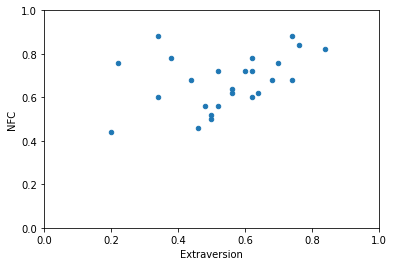

In [16]:
experiment_level_data.plot.scatter(x='Extraversion', y='NFC');
plt.xlim([0, 1])
plt.ylim([0, 1]);
savefig('trait_distribution')
HTML("""
We collected 10 items each for NFC and Extraversion.
We obtained a wider range of Extraversion than NFC.
(Min and max scales normalized to 0 and 1 respectively.)""")

In [17]:
def latexify_conds(txt):
    for cond in 'norecs specific general'.split():
        txt = txt.replace(cond, f'\\S{cond}')
    return txt

In [18]:
covc = experiment_level_data.condition_order.value_counts()
covc.name = 'Num participants'
covc = covc.to_latex()
covc = covc.replace(',', ', ')
covc = latexify_conds(covc)
print(covc)
data['condition_order_table'] = covc

\begin{tabular}{lr}
\toprule
{} &  Num participants \\
\midrule
\Snorecs, \Sgeneral, \Sspecific &                 6 \\
\Snorecs, \Sspecific, \Sgeneral &                 4 \\
\Sgeneral, \Snorecs, \Sspecific &                 4 \\
\Sgeneral, \Sspecific, \Snorecs &                 4 \\
\Sspecific, \Sgeneral, \Snorecs &                 3 \\
\Sspecific, \Snorecs, \Sgeneral &                 3 \\
\bottomrule
\end{tabular}



In [19]:
HTML("""When running this experiment, the experiment software was configured to randomize the order
of conditions seen by each subject, not to attempt to counterbalance order.
This was fixed in subsequent experiments."""
     + experiment_level_data.condition_order.value_counts().to_frame().to_html())

,condition_order
"norecs,general,specific",6
"norecs,specific,general",4
"general,norecs,specific",4
"general,specific,norecs",4
"specific,general,norecs",3
"specific,norecs,general",3


In [20]:
def summarize_means(df, by, outcome):
    means = df.groupby(by)[outcome].mean()
    data[f'{outcome}_means'] = means
    return ', '.join(f'{name}={group_mean:.2f}' for name, group_mean in means.iteritems())

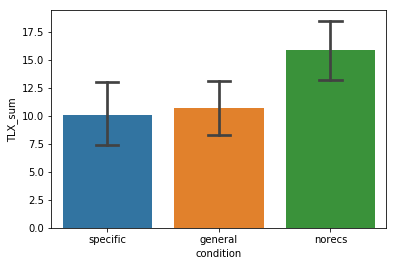

In [21]:
sns.barplot(x='condition', y='TLX_sum', data=block_level_data, capsize=.2)
savefig('cogload')
HTML("The average cognitive load was higher in the no-recommendations condition ({})".format(
    summarize_means(block_level_data, 'condition', 'TLX_sum')))

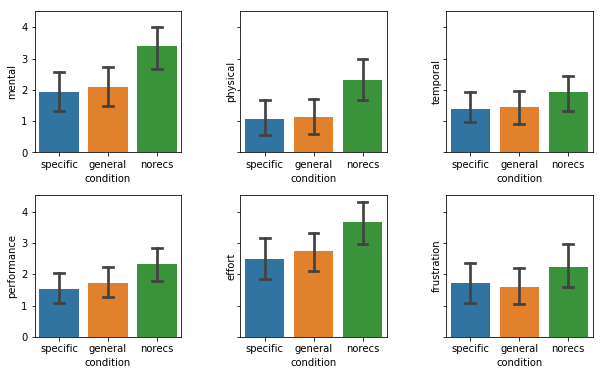

In [22]:
tlxen = 'mental physical temporal performance effort frustration'.split()
fig, axs = plt.subplots(2, 3, figsize=(10,6), sharey=True)
plt.subplots_adjust(wspace=.4, hspace=.3)
for i, facet in enumerate(tlxen):
    ax = axs.ravel()[i]
    sns.barplot(x='condition', y=facet, data=block_level_data, capsize=.2, ax=ax)
savefig('tlx_parts')

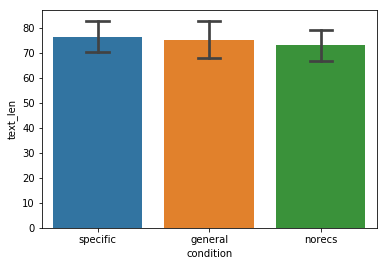

In [23]:
sns.barplot(x='condition', y='text_len', data=trial_level_data, capsize=.2);
savefig('textlen')
HTML("There was no difference in text length between conditions ({}).".format(
    summarize_means(trial_level_data, 'condition', 'text_len')))

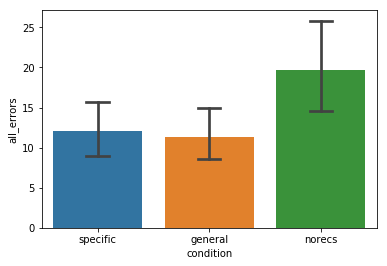

In [24]:
sns.barplot(x='condition', y='all_errors', data=trial_level_data, capsize=.2)
HTML("Participants made more errors (corrected + uncorrected) in the no-recommendations condition ({}).".format(
    summarize_means(trial_level_data, 'condition', 'all_errors')))

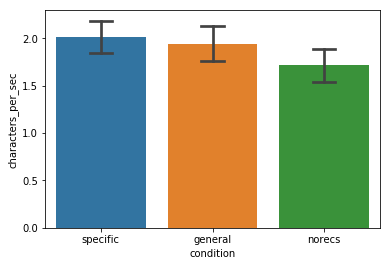

In [25]:
sns.barplot(x='condition', y='characters_per_sec', data=trial_level_data, capsize=.2)
savefig('chars_per_sec')
HTML("Participants were slightly faster in the recommendations conditions (characters per second: {}).".format(
    summarize_means(trial_level_data, 'condition', 'characters_per_sec')))

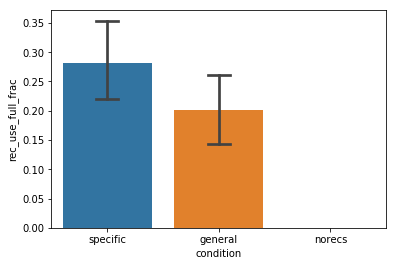

In [26]:
sns.barplot(x='condition', y='rec_use_full_frac', data=trial_level_data, capsize=.2)
HTML("Participants used available recommendations slightly more often when they were specific (use rate: {}).".format(
    summarize_means(trial_level_data, 'condition', 'rec_use_full_frac')))

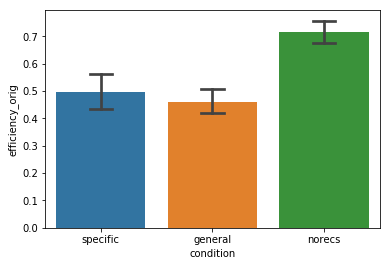

In [27]:
sns.barplot(x='condition', y='efficiency_orig', data=trial_level_data, capsize=.2)

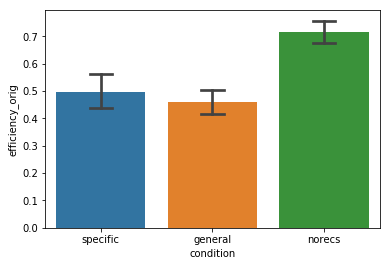

In [28]:
sns.barplot(x='condition', y='efficiency_orig', data=trial_level_data, capsize=.2)

In [29]:
print('\n\n'.join(x for x in experiment_level_data['techDiff'] if x is not None))

None

None

Mone

No

None

None

No

No issues

No 

No

None

No

No

None

None

Nope

None.

No

None

Just the fact that the third photo in keyboard 1 never loaded.

None

None

None

None

No. 


In [30]:
print('\n\n'.join(x for x in experiment_level_data['other'] if isinstance(x, str)))

No, I really enjoyed this task ☺️

None

None

It went well but my initial survey responses might not be in complete alignment with my final responses on this page.  That's because seeing my captions on this page gave me a better perspective with the benefit of hindsight.  Thanks for the HIT!  I did my best and hope the data is useful!

Being able to not have to backspace to redo typing

None

None

None

None

None

This was very annoying

Everything was great. First and third were pretty equal. Second was awful.

It went smooth no issues 

None

Everything went smoothly. Thank you

Can I type this one on the computer? One: I love the fact that after going to this page straight from the HIT on my computer, the page stayed synced when I went to it from my phone. There are some HITs I've done that could really benefit from that little nicety. Two: I feel like the suggestions really tend toward making me lazy, to some small extent. Having to type it all, you have to think about what to s

In [39]:
num_details = pd.read_csv(paths.data / 'num_details_spec1.csv').rename(columns={
    'image_id': 'stimulus',
    'text': 'corrected_text'
})

In [40]:
num_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 3 columns):
stimulus          216 non-null int64
corrected_text    216 non-null object
num_details       216 non-null int64
dtypes: int64(2), object(1)
memory usage: 5.1+ KB


In [41]:
with_num_details = pd.merge(
    trial_level_data,
    num_details,
    on=('stimulus', 'corrected_text'),
#     right_on=('image_id', 'text'),
    how='outer')

In [42]:
with_num_details

,participant,age,english_proficiency,gender,helpfulRank-accurate-least-condition,helpfulRank-accurate-least-idx,helpfulRank-accurate-most-condition,helpfulRank-accurate-most-idx,helpfulRank-quick-least-condition,helpfulRank-quick-least-idx,...,delay_before_start,seconds_spent_typing,taps_per_second,ideal_num_taps_orig,efficiency_orig,final_text_for_correction,corrected_text,uncorrected_errors,all_errors,num_details
0,26w4jv,37.0,Native or bilingual,Female,specific,0,specific,0,norecs,2,...,13.904,14.259,0.911705,13,1.000000,a cat sitting on top of the table next to a wi...,a cat sitting on top of the table next to a wi...,0,0,3
1,26w4jv,37.0,Native or bilingual,Female,specific,0,specific,0,norecs,2,...,12.029,33.505,0.626772,16,0.761905,a shower with a towel hanging on the handle of...,a shower with a towel hanging on the handle of...,0,2,4
2,26w4jv,37.0,Native or bilingual,Female,specific,0,specific,0,norecs,2,...,3.346,54.663,0.676875,22,0.594595,a bathroom with a toilet and sink and with a r...,a bathroom with a toilet and sink and with a r...,0,8,4
3,26w4jv,37.0,Native or bilingual,Female,specific,0,specific,0,norecs,2,...,12.752,38.536,0.856342,21,0.636364,a man and woman getting assistance cutting the...,a man and woman getting assistance cutting the...,0,0,2
4,26w4jv,37.0,Native or bilingual,Female,specific,0,specific,0,norecs,2,...,9.595,33.308,1.140867,13,0.342105,a man assisting children with flying kites,a man assisting children with flying kites,0,9,6
5,26w4jv,37.0,Native or bilingual,Female,specific,0,specific,0,norecs,2,...,7.566,31.789,0.754978,13,0.541667,a train is traveling on the tracks through a m...,a train is traveling on the tracks through a m...,0,4,1
6,26w4jv,37.0,Native or bilingual,Female,specific,0,specific,0,norecs,2,...,6.358,33.439,1.405544,39,0.829787,a red city bus heading down the street,a red city bus heading down the street,0,4,3
7,26w4jv,37.0,Native or bilingual,Female,specific,0,specific,0,norecs,2,...,2.449,114.635,0.662974,66,0.868421,a man with a tennis rackett forcefully swingin...,a man with a tennis racket forcefully swinging...,1,6,6
8,26w4jv,37.0,Native or bilingual,Female,specific,0,specific,0,norecs,2,...,7.666,63.491,1.118269,55,0.774648,a man-woman gracefully riding a wave using a s...,a man-woman gracefully riding a wave using a s...,0,8,1
9,3267ww,28.0,Fluent,Female,norecs,1,specific,0,norecs,1,...,8.222,21.155,0.756322,10,0.625000,a cat is sitting behind a glass of wine,a cat is sitting behind a glass of wine,0,0,3


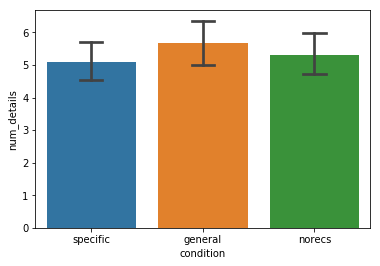

In [43]:
sns.barplot(x='condition', y='num_details', data=with_num_details, capsize=.2)

In [45]:
with_num_details.num_details.describe()

count    216.000000
mean       5.351852
std        2.826173
min        0.000000
25%        4.000000
50%        5.000000
75%        7.000000
max       15.000000
Name: num_details, dtype: float64

In [48]:
print('\n'.join(with_num_details.sort_values('num_details').text.iloc[-5:]))

looking down a london street on a crowded evening with a london double bus in clear focus and old-style buildings next to each other on both sides
in a drab yellow bathroom is a very clinical white sink with an unadorned mirror above and adjacent white toilet with a roll of toilet paper on top
a city view of a busy london street filled with a black car and a red double decker bus driving on the street. many people fill the sidewalk mostly the right side
sliding glass, frosted, shower doors with a tan towel hanging on the handle and a white toilet with a blue floor rug
a bathroom with one white sink and a white toilet with a toilet paper roll on the back lid sits next to the sink which has a mirror above it which shows the exact same toilet across the room


In [44]:
with_num_details.to_csv('with_num_details.csv')

In [32]:
import pickle
pickle.dump({batch: data}, open(paths.analyzed / 'data.pkl', 'wb'), -1)

In [33]:
assert False

AssertionError: 

In [ ]:
from textrec import onmt_model_2

In [ ]:
def get_recs_cap(cocoid, context, prefix=None):
    return onmt_model_2.get_recs('coco_cap', str(cocoid), context, prefix=prefix)

def get_recs_lm(cocoid, context, prefix=None):
    return onmt_model_2.get_recs('coco_lm', '.', context, prefix=prefix)

In [ ]:
get_recs_cap(71815, 'a'.split(), prefix='t')

In [ ]:
from functools import partial

In [ ]:
txt = "a tennis player swinging at a ball"
txt[:0].rsplit(' ', 1)

In [ ]:
txt.rindex(' ')

In [ ]:
def taps_to_type(rec_gen, txt):
    actions = []
    # Invariant: performing [actions] types txt[:idx]
    idx = 0
    while idx < len(txt):
        sofar = txt[:idx]
        if ' ' in sofar:
            last_space_idx = sofar.rindex(' ')
        else:
            last_space_idx = -1
        prefix = sofar[:last_space_idx + 1]
        cur_word = sofar[last_space_idx + 1:]
        cur_desired_word = txt[last_space_idx + 1:].split(' ', 1)[0]
#         if cur_desired_word[-1] in ',.;-':
#             cur_desired_word = cur_desired_word[:-1]
#         print(repr(prefix), repr(cur_word), repr(cur_desired_word))
        recs = rec_gen(onmt_model_2.tokenize(prefix), prefix=cur_word)
        words = [word for word, rec in recs]
        print(prefix, words)
        if cur_desired_word in words:
            actions.append(dict(type='rec', which=words.index(cur_desired_word), word=cur_desired_word))
            idx = last_space_idx + 1 + len(cur_desired_word) + 1
        else:
            actions.append(dict(type='key', key=txt[idx]))
            idx += 1
        print(actions[-1])
    return actions
taps_to_type(partial(get_recs_cap, 71815), "a young man wearing a red shirt and holding a white and red tennis racket")

In [ ]:
if False:
    writer = pd.ExcelWriter('specificity_details.xlsx')
    for stim, group in trial_level_data.groupby('stimulus'):
        group.loc[:,['corrected_text']].to_excel(writer, str(stim))
    writer.close()

In [ ]:
if False:
    for stim, txts in trial_level_data.groupby('stimulus').text:
        print()
        print(stim)
        print('\n'.join(txts))
        txts.to_csv(f'{stim}.csv', index=False)